# Blackbox Optimization with Linear and Logarithmic models

In [1]:
## Libraries
import sys
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# https://docs.scipy.org/doc/scipy/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs
import scipy.optimize as optimize

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
sys.path.append("myfun/")
from ipynb.fs.defs.myfun_models import *

2023-09-06 10:09:57.349468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


# Step 1: Synthetic data

## Why synthetic data?
Synthetic data is information that's artificially manufactured rather than generated by real-world events. It's created algorithmically and is used as a stand-in for test data sets of production or operational data, to validate mathematical models and to train machine learning (ML) models.

## Create synthetic data

In [2]:
# time discretization
Nt, T = 100, 10                             # Number of time steps, final time
ts = np.linspace(0, T, Nt)                  # timespan

N = 5                                       # numbers of vehicles
X0 = sorted(np.random.uniform(size=N)*100)  # initial condition
v0, L = 2, 3                                # control param
flag = "Lin"
args=(N, v0, L, flag)

In [3]:
## Solve the ode with "odeint"
X = odeint(TD_LWR_model, X0, ts, args=(N, v0, L, flag), tfirst = True).T # take the transpose to get N trajs!

In [4]:
# Take samples from the simulation
M = 10           # Number of samples
Mt = int(Nt/M)   # timestamp to take equispaced samples

idx = list(range(0,Nt,Mt+1))    # indexes to extract
tshat, Xhat = ts[idx], [traj[idx] for traj in X]

In [5]:
idx

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99]

In [6]:
tshat

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [7]:
Xhat

[array([ 1.65754621,  3.64960238,  5.63786834,  7.62252357,  9.60372759,
        11.58162448, 13.55634618, 15.52801488, 17.49674482, 19.46264361]),
 array([30.87106742, 32.37371683, 33.91165056, 35.47948812, 37.07308401,
        38.6891642 , 40.3250909 , 41.97870144, 43.64819649, 45.33206053]),
 array([39.88707836, 41.88520906, 43.88337182, 45.88157823, 47.8798395 ,
        49.8781665 , 51.87656979, 53.87505958, 55.87364577, 57.87233796]),
 array([69.63522243, 71.63682686, 73.64002457, 75.64478154, 77.65106493,
        79.65884305, 81.66808527, 83.67876202, 85.69084469, 87.70430562]),
 array([ 99.74308615, 101.96530837, 104.18753059, 106.40975281,
        108.63197503, 110.85419726, 113.07641948, 115.2986417 ,
        117.52086392, 119.74308615])]

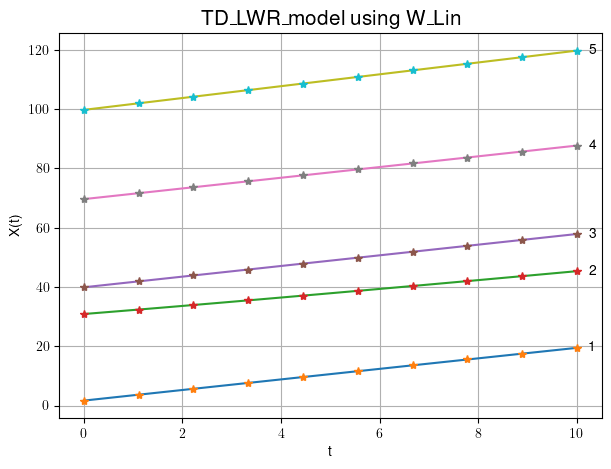

In [8]:
# fig 
width, height = 7, 5
# palette = 'darkblue'
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    # X.T (transposed) is the list of trajectories of the vehicles
    ax.plot(ts, X[veh])
    ax.plot(tshat, Xhat[veh], '*')

# Annotate the name of each variable at the last value
scale = 1.025
last_val = X[:,-1].tolist()
coords = zip([T*scale]*N,last_val) # last value where I want to annotate the corresponding label
labels = list(range(1,N+1,1))

for coord,lab in zip(coords,labels):
    ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                xytext=coord,                # The position (x, y) to place the text at.
#                 textcoords='offset points',
                text=lab,
                verticalalignment='center')

    
ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(f"TD_LWR_model using W_{flag}", fontsize=15)
plt.grid()
plt.show()

# Step 2: Optimization with blackbox approach

In [9]:
#A = np.array([np.random.sample(N)*20 for i in range(0,Mt)])

In [10]:
# definition with freezed parameteres X0, N, ts and flag.
def f(v0,L):
    return odeint(TD_LWR_model, X0, ts, args=(N, v0, L, flag), tfirst = True).T

In [11]:
def loss_fun(params):
    "Loss function"
    
    v0, L = params # whereas X0, N, ts and flag are fixed
    X = f(v0,L)
        
    # extracting the same index as the sampled one
    Xupd = [traj[idx] for traj in X]
            
    mse = mean_squared_error(Xhat, Xupd)
    return mse

In [12]:
# using the parameters used in the creation of synthetic data the loss must be 0!
loss_fun([v0,L])

0.0

In [13]:
v0, L

(2, 3)

In [14]:
initial_guess = [3,9]

# first attempt: without using Jac
result = optimize.minimize(loss_fun, initial_guess, method="CG")
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5416031522745D+01   r2 =  0.2996929193375D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5416031522746D+01   r2 =  0.2680915844019D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5416031522746D+01   r2 =  0.3083053220621D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5416031522746D+01   r2 =  0.3083053220621D-15
 lsoda--  warning..internal t (=r1) 

/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/andrea/anaconda3/envs/tesi/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [15]:
fitted_params.tolist()

[2.000000154980275, 3.0000011641051305]